# locate variants & non-synonymous variants from SAMFIRE output

put full path to single_locus_trajectories.out file, full path to reference .dat file, desired coverage cutoff, and desired minimum variant frequency below

In [78]:
variant_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Single_locus_trajectories10.out"

println(variant_path)

ref_dat_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames.dat"

println(ref_dat_path)

In [79]:
# Load Pkg for package management
using Pkg

# Define a list of required packages
required_packages = ["DataFrames", "CategoricalArrays", "RCall", "FileIO", "Images"]

# Check if each package is installed, install if not, and then use it
for pkg in required_packages
    if pkg ∉ keys(Pkg.dependencies())
        println("Installing $pkg...")
        Pkg.add(pkg)
    end
    println("Using $pkg...")
    using $(Symbol(pkg))
end

# Load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Check and load the BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
end

# Function to handle permission issues and force reinstall if needed
install_if_missing <- function(pkg) {
  if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
    BiocManager::install(pkg, ask = FALSE, force = TRUE)
  }
}

# Apply function to Biostrings, and install ggplot2 and viridis with dependencies
install_if_missing("Biostrings")
install.packages(c("ggplot2", "viridis"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("Biostrings")
  library("ggplot2")
  library("viridis")
})
"""


TypeError: TypeError: in using, expected Symbol, got a value of type Expr

In [80]:
# read variants file into a dataframe

# Define the function to read the .out file
function read_out_file(filepath::String)
    # Initialize an empty DataFrame
    df = DataFrame(pos = Int[], original_base = String[], variant_base = String[])
    
    # Open the file and process each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Remove any leading/trailing whitespace
            stripped_line = strip(line)
            
            # Continue only if the line is not empty
            if !isempty(stripped_line)
                # Split the line into parts, typically space-delimited
                parts = split(stripped_line)
                
                # Ensure there are enough parts to avoid index errors
                if length(parts) < 3
                    continue  # Skip this line if it doesn't have enough parts
                end

                # Extract the position, original base, and variant base
                pos = parse(Int, parts[1])
                original_base = parts[2]  # Should be a single character string
                variant_base = parts[3]   # Should be a single character string
                
                # Append to the DataFrame
                push!(df, (pos, original_base, variant_base))
            end
        end
    end
    
    return df
end

variants = read_out_file(variant_path)

# create a column with mutation directions e.g. A->T

function call_muts(df::DataFrame)
    # Check if the required columns are present in the DataFrame
    if !("original_base" in names(df) && "variant_base" in names(df))
        error("DataFrame must contain 'original_base' and 'variant_base' columns")
    end

    # Create a new column 'mutation' by concatenating 'original_base', '->', 'variant_base'
    mutations = df.original_base .* "->" .* df.variant_base

    # Define the order of categories
    levels_order = ["A->C", "A->G", "A->T", "C->A", "C->G", "C->T", "G->A", "G->C", "G->T", "T->A", "T->C", "T->G"]

    # Convert 'mutations' into a categorical array with predefined levels
    df.mutation = categorical(mutations, ordered=true, levels=levels_order)
    
    return df
end

variants = call_muts(variants)

Row,pos,original_base,variant_base,mutation
,Int64,String,String,Cat…
1,11,A,G,A->G
2,18,A,G,A->G
3,141,G,A,G->A
4,144,G,T,G->T
5,380,T,C,T->C
6,576,G,A,G->A
7,754,A,G,A->G
8,811,C,T,C->T
9,977,C,A,C->A


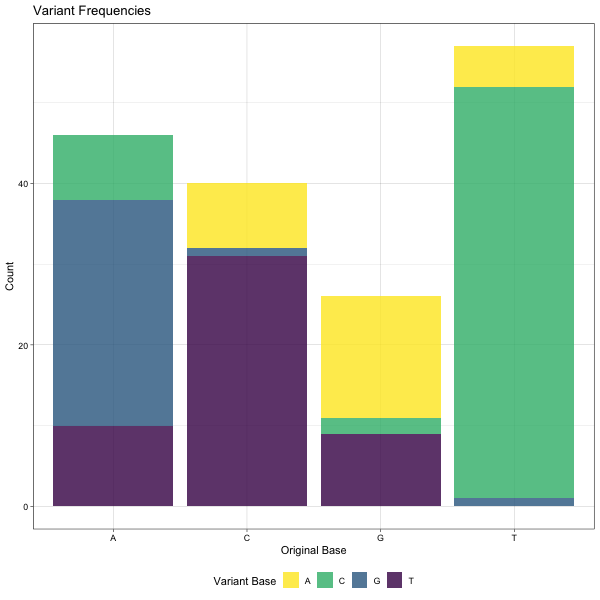

In [81]:
# barplot of mutation frequencies

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- ggplot(variants, aes(x = original_base, fill = variant_base)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variant Frequencies", x = "Original Base", y = "Count", fill = "Variant Base") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1)

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end


In [82]:
# pull two .fas from .dat file 

# Function to handle the .dat file processing
function pull_frames(dat_file_path::String)
    # Define the paths for the .fa files in Julia before calling R
    nucleotide_fasta_path = replace(dat_file_path, ".dat" => "_nucleotide.fa")
    aa_fasta_path = replace(dat_file_path, ".dat" => "_amino_acid.fa")

    # Pass the file paths to R
    @rput dat_file_path
    @rput nucleotide_fasta_path
    @rput aa_fasta_path

    R"""
    library(Biostrings)
    library(stringr)
    process_file <- function(dat_file_path, fasta_nucleotide_path, fasta_amino_acid_path) {
        lines <- tryCatch({
            readLines(dat_file_path)
        }, error = function(e) {
            cat("Error reading file:", e$message, "\n")
            return(NULL)  # Return NULL to handle error gracefully
        })
        if (is.null(lines)) return()  # Exit if file could not be read

        con_nuc <- file(fasta_nucleotide_path, open = "w")
        con_aa <- file(fasta_amino_acid_path, open = "w")
        
        for (i in seq(1, length(lines), by = 3)) {
            if (i + 2 > length(lines)) {
                break
            }
            header <- strsplit(lines[i], " ")[[1]]
            if (length(header) < 3) {
                next
            }
            start_pos <- header[1]
            end_pos <- header[2]
            annotation <- paste(header[3:length(header)], collapse=" ")
            full_annotation <- paste0('"accession":', start_pos, '..', end_pos, ' | ', annotation)
            dna_seq <- DNAString(lines[i+1])
            aa_seq <- AAString(lines[i+2])
            
            writeLines(paste0(">", full_annotation), con_nuc)
            writeLines(as.character(dna_seq), con_nuc)
            writeLines(paste0(">", full_annotation), con_aa)
            writeLines(as.character(aa_seq), con_aa)
        }
        
        close(con_nuc)
        close(con_aa)
    }
    """
    # Call the R function from Julia with paths
    R"process_file($(dat_file_path), $(nucleotide_fasta_path), $(aa_fasta_path))"
    
    # Julia prints and retains the paths in variables
    println("nucleotide .fa : ", nucleotide_fasta_path)
    println("amino acid .fa : ", aa_fasta_path)

    return nucleotide_fasta_path, aa_fasta_path
end


nucleotide_fasta_path, aa_fasta_path = pull_frames(ref_dat_path)

("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_nucleotide.fa", "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_amino_acid.fa")

In [83]:
# pull nucleotide and amino acid .fa files from .dat file

function pull_fasta(fasta_path::String)
    # Read the fasta file using Biostrings in R
    R"""
    library(Biostrings)
    library(stringr)
    dna_seqs <- readDNAStringSet($(fasta_path))
    headers <- names(dna_seqs)
    
    # Parse headers to extract Accession, Start, End, and Protein
    accession <- str_extract(headers, "^[^:]+")
    range <- str_extract(headers, "\\d+\\.\\.\\d+")
    start <- as.integer(sub("\\.\\..*$", "", range))
    end <- as.integer(sub("^.*\\.\\.", "", range))
    protein <- str_extract(headers, "\\|\\s*(.*)$")
    protein <- str_trim(str_sub(protein, str_locate(protein, "\\|")[[1]] + 1)) # Trim pipe and whitespace
    """

    # Convert R data to Julia DataFrame
    accessions = rcopy(R"accession")
    starts = rcopy(R"start")
    ends = rcopy(R"end")
    proteins = rcopy(R"protein")
    sequences = rcopy(R"sapply(dna_seqs, as.character)")

    # Create a DataFrame from the extracted data
    fasta_df = DataFrame(
        protein = proteins,
        start_pos = starts,
        end_pos = ends,
        sequence = sequences
    )

    return fasta_df
end

fasta_df = pull_fasta(nucleotide_fasta_path)

Row,protein,start_pos,end_pos,sequence
,String,Int64,Int64,String
1,NS1,77,496,ATGGGCAGCAACTCATTGAGTATGATAAAAGTTAGATTGCAAAATCTGTTTGACAATGATGAAGTAGCATTGTTAAAAATAACATGTTATACTGACAAATTAATACAGTTAACTAATGCTTTGGCTAAGGCAGTTATACATACAATCAAATTGAATGGCATTGTATTTGTGCATGTTATTACAAGTAGTGATATTTGCCCTAATAATAATATTGTAGTGAAATCCAATTTCACAACAATGCCAGTATTACAAAATGGAGGTTATATATGGGAAATGATGGAATTAACACACTGCTCTCAACCTAATGGCCTAATAGATGACAATTGTGAAATTAAATTCTCCAAAAAACTAAGTGATTCAACAATGACCAATTATATGAATCAATTATCTGAATTACTTGGATTTGACCTCAATCCATAA
2,NS2,606,980,ATGGACACAACACACAATGATACCACACCACAAAGACTGATGATCACAGACATGAGACCATTATCGCTTGAAACTATAATAACATCTCTAACCAGAGACATCATAACACATAAATTTATATACTTGATAAATCATGAATGCATAGTGAGAAAACTTGATGAAAGACAGGCCACATTTACATTTCTGGTCAACTATGAAATGAAACTATTGCACAAAGTGGGAAGCACTAAATATAAAAAATATACTGAATACAACACAAAATATGGCACTTTCCCTATGCCAATATTTATCAATCATGATGGGTTCTTAGAATGCATTGGCATTAAGCCCACCAAGCACACACCCATAATATACAAGTACGATCTCAATCCATGA
3,N (Nucleoprotein),1094,2293,ATGAAAGATGGGGCAAATACAAAAATGGCTCTTAGCAAAGTCAAGTTGAATGATACACTCAACAAAGATCAACTTCTATCATCCAGCAAATATACCATCCAACGGAGCACAGGAGACAGCATTGACACTCCTAATTATGATGTGCAGAAACACATTAATAAGTTATGTGGCATGTTATTAATCACAGAAGATGCTAATCACAAATTCACTGGGTTAATAGGTATGTTATATGCTATGTCTAGATTAGGAAGAGAAGACACCATAAAAATACTCAAAGATGCGGGATATCATGTTAAGGCAAATGGAGTGGATGTAACAACACATCGTCAAGACATTAATGGGAAAGAAATGAAATTTGAAGTGTTAACATTAGCAAGCTTAACAACTGAAATTCAAATCAACATTGAGATAGAATCTAGAAAATCCTACAAAAAAATGCTAAAAGAAATGGGAGAGGTGGCTCCAGAATACAGGCATGACTCTCCTGATTGTGGGATGATAATATTATGTATAGCAGCATTAGTAATAACCAAATTAGCAGCAGGAGATAGATCAGGTCTTACAGCTGTGATTAGGAGAGCTAACAATGTTCTAAAAAATGAAATGAAACGTTATAAAGGTTTATTACCCAAGGATATAGCCAACAGCTTCTATGAAGTGTTTGAAAAATATCCTCACTTTATAGATGTTTTTGTTCATTTTGGTATAGCACAATCTTCTACCAGAGGTGGCAGTAGAGTTGAAGGGATTTTCGCAGGATTGTTTATGAATGCCTATGGTGCAGGGCAAGTGATGTTACGGTGGGGGGTCTTAGCAAAATCAGTTAAAAACATTATGTTAGGACACGCTAGTGTACAAGCAGAAATGGAACAAGTTGTGGAGGTGTATGAGTATGCTCAGAAATTGGGTGGAGAAGCAGGATTCTACCATATATTGAACAACCCAAAGGCATCACTATTATCTTTGACTCAATTTCCTCACTTCTCTAGTGTAGTATTGGGCAATGCTGCTGGCCTAGGCATAATGGGAGAATACAGAGGTACACCAAGGAATCAAGATTTATATGATGCTGCAAAAGCATATGCTGAACAACTCAAAGAAAATGGTGTGATTAACTACAGTGTATTAGATTTGACAGCAGAAGAACTAGAGGCTATCAAACATCAGCTTAATCCAAAAGATAATGATGTAGAGCTTTGA
4,P (Phosphoprotein),2325,3050,ATGGAAAAGTTTGCTCCTGAATTCCATGGAGAAGATGCAAACAACAGAGCCACCAAATTCCTAGAATCAATAAAGGGCAAATTCACATCACCCAAAGATCCCAAGAAAAAAGATAGTATCATATCTGTCAACTCAATAGATATAGAAGTAACCAAAGAAAGCCCTATAACATCAAACTCAACCACTATAAACCCAATAAATGAGACAGATGATACTGTAGGGAACAAGCCCAATTATCAAAGAAAGCCTCTAGTAAGTTTCAAAGAAGACCCTACGCCAAGTGATAATCCTTTTTCAAAACTATACAAAGAAACCATAGAAACATTTGATAACAATGAAGAAGAGTCTAGCTATTCATATGAAGAAATAAATGATCAGACAAACGATAATATAACAGCAAGATTAGATAGGATTGATGAGAAATTAAGTGAAATACTAGGAATGCTTCACACATTAGTAGTAGCGAGTGCAGGACCCACATCTGCTCGGGATGGTATAAGAGATGCCATGGTTGGTTTAAGAGAAGAAATGATAGAAAAAATCAGAACTGAAGCATTAATGACCAATGACAGACTAGAAGCTATGGCAAGACTCAGGAATGAAGAAAGTGAAAAGATGGCAAAAGACACATCAGATGAAGTGTCTCTCAATCCAACATCAGAGAAACTGAACAACCTGTTGGAAGGGAATGATAGTGACAATGATCTATCACTTGAAGATTTCTGA
5,Matrix,3233,4003,ATGGAAACATACGTGAATAAACTTCACGAAGGCTCCACATACACAGCTGCTGTTCAATACAATGTCCTAGAAAAAGACGATGATCCTGCATCACTTACAATATGGGTGCCCATGTTCCAATCATCCATGCCAGCAGATCTACTCATAAAAGAACTAGCCAATGTCAATATACTAGTGAAACAAATATCCACACCCAAGGGACCCTCATTAAGAGTCATGATAAACTCAAGAAGTGCAGTGCTAGCACAAATGCCCAGCAAATTTACCATATGTGCCAATGTGTCCTTGGATGAAAGAAGCAAGCTGGCATATGATGTAACCACACCCTGTGAAATTAAGGCATGCAGTCTAACATGCCTAAAATCAAAAAATATGTTAACTACAGTTAAAGATCTCACTATGAAAACACTCAACCCAACACATGACATCATTGCTTTATGTGAATTTGAAAATATAGTAACATCAAAAAAAGTCATAATACCAACATACCTAAGATCTATCAGCGTCAGAAATAAAGATCTGAACACACTCGAAAATATAACAACCACTGAATTCAAAAATGCCATTACAAATGCAAAAATCATCCCTTACTCAGGACTACTGTTAGTCATCACAGTGACTGACAACAAAGGAGCATTCAAATACATAAAGCCACAAAGTCAATTCATAGTAGATCTTGGAGCTTACCTAGAAAAAGAAAGTATATATTATGTCACAACAAATTGGAAGCACACAGCTACACGATTTGCAATCAAACCCATGGAAGATTAA
6,SH protein,4273,4467,ATGGAAAATACATCCATAACTATAGAATTCTCAAGCAAATTCTGGCCTTACTTTACACTAATACACATGATAACAACAATAATCTCTTTGATAATCATAATCTCCATCATGATTGCAATACTAAACAAACTCTGCGAATATAATGTATTCCATAACAAAACCTTTGAGCTACCAAGAGCTCGAGTCAATACATAG
7,G Glycoprotein,4659,5624,ATGTCCAAAACCAAGGACCAACGCACCGCCAAGACACTAGAAAGGACCTGGGACACTCTCAATCATCTATTATTCATATCATCG

In [84]:
# match proteins by position 

function call_proteins(variants_df::DataFrame, fasta_df::DataFrame)
    # Initialize an empty DataFrame for results, pre-defining the columns by combining both DataFrame's columns
    cols = names(variants_df)
    append!(cols, names(fasta_df))
    result_df = DataFrame(; [Symbol(col) => Any[] for col in cols]...)

    # Iterate over each row in variants_df
    for variant in eachrow(variants_df)
        pos = variant[:pos]  # Accessing the 'pos' column in variants_df

        # Filter fasta_df to find rows where 'pos' is between 'start_pos' and 'end_pos'
        matches = filter(row -> row[:start_pos] <= pos <= row[:end_pos], fasta_df)

        # For each match, concatenate the row from variants_df with the row from fasta_df
        for match in eachrow(matches)
            # Create a new row by extracting the data from both variant and match
            new_row = [variant[coln] for coln in names(variants_df)]
            append!(new_row, [match[coln] for coln in names(fasta_df)])
            push!(result_df, new_row)
        end
    end

    return result_df
end

variants = call_proteins(variants, fasta_df)

# retype columns

# Convert 'pos' to Int64 if it's not already an integer
variants.pos = variants.pos isa AbstractArray{Int} ? variants.pos : parse.(Int, string.(variants.pos))

# Convert 'original_base', 'variant_base', 'mutation', and 'Sequence' to String
variants.original_base = string.(variants.original_base)
variants.variant_base = string.(variants.variant_base)
variants.mutation = string.(variants.mutation)
variants.sequence = string.(variants.sequence)

# Convert 'Protein' to categorical
variants.protein = categorical(variants.protein)

# Convert 'Start' and 'End' to Int64 if they're not already integers
variants.start_pos = variants.start_pos isa AbstractArray{Int} ? variants.start_pos : parse.(Int, string.(variants.start_pos))
variants.end_pos = variants.end_pos isa AbstractArray{Int} ? variants.end_pos : parse.(Int, string.(variants.end_pos))

# Print the modified dataframe
println(variants)


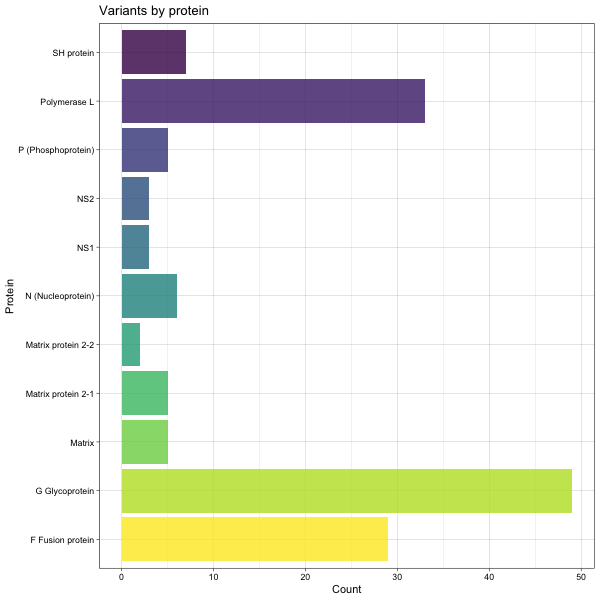

In [85]:
# barplot of variants by protein

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- ggplot(variants, aes(x = protein, fill = protein)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variants by protein", x = "Protein", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end


In [86]:
# create variant sequence
function substitute_variants(dataframe::DataFrame)
    # Create a new column for Base_Position
    dataframe.adj_pos = dataframe.pos .- dataframe.start_pos

    # Create a new column for variant_sequence
    dataframe.variant_sequence = Vector{String}(undef, nrow(dataframe))

    # Iterate over each row in the DataFrame
    for i in 1:nrow(dataframe)
        # Extract the original sequence
        sequence = string(dataframe[i, :sequence])

        # Extract the variant position
        adjusted_variant_position = dataframe[i, :adj_pos]

        # Check if the variant position is within the sequence length
        if 1 <= adjusted_variant_position <= length(sequence)
            # Extract the variant base
            variant_base = string(dataframe[i, :variant_base])

            # Check if the character at Base_Position is equal to Original_Base
            original_base = string(sequence[adjusted_variant_position])
            if original_base != dataframe[i, :original_base]
                println("Warning: Original_Base in row $i does not match base at position $adjusted_variant_position in the Sequence.")
            end

            # Create the new sequence with the substitution
            new_sequence = string(sequence[1:adjusted_variant_position-1], variant_base, sequence[adjusted_variant_position+1:end])

            # Update the variant_sequence column
            dataframe[i, :variant_sequence] = new_sequence
        end
    end

    return dataframe
end

variants = substitute_variants(variants)

println(variants)

In [87]:
# pull out original & variant codons and translate 
# find original codons
function find_original_codons(df::DataFrame)
    # Function to split a DNA sequence into codons
    function split_into_codons(sequence)
        return [sequence[i:i+2] for i in 1:3:length(sequence)-2]
    end
    
    # Process each row in the DataFrame
    codons = []
    for row in 1:size(df, 1)
        sequence = string(df[row, :sequence])
        base_position = df[row, :adj_pos]
        
        # Check if base_position is valid
        if base_position < 1 || base_position > length(sequence)
            throw(ArgumentError("Invalid Base_Position for row $row"))
        end
        
        # Extract the codon based on the Adj_Variant_Position
        codon_index = (base_position - 1) ÷ 3 + 1
        push!(codons, split_into_codons(sequence)[codon_index])
    end
    
    # Add the codons as a new column in the DataFrame
    df[!, :original_codon] = codons
    
    return df
end

variants = find_original_codons(variants)

# find variant codons
function find_variant_codons(df::DataFrame)
    # Function to split a DNA sequence into codons
    function split_into_codons(sequence)
        return [sequence[i:i+2] for i in 1:3:length(sequence)-2]
    end
    
    # Process each row in the DataFrame
    codons = []
    for row in 1:size(df, 1)
        sequence = string(df[row, :variant_sequence])
        base_position = df[row, :adj_pos]
        
        # Check if base_position is valid
        if base_position < 1 || base_position > length(sequence)
            throw(ArgumentError("Invalid Base_Position for row $row"))
        end
        
        # Extract the codon based on the Adj_Variant_Position
        codon_index = (base_position - 1) ÷ 3 + 1
        push!(codons, split_into_codons(sequence)[codon_index])
    end
    
    # Add the codons as a new column in the DataFrame
    df[!, :variant_codon] = codons
    
    return df
end

variants = find_variant_codons(variants)

# Function to map codons to amino acids
function codon_to_aa(codon)
    codon_dict = Dict("TTT" => "F", "TTC" => "F", "TTA" => "L", "TTG" => "L",
                        "CTT" => "L", "CTC" => "L", "CTA" => "L", "CTG" => "L",
                        "ATT" => "I", "ATC" => "I", "ATA" => "I", "ATG" => "M",
                        "GTT" => "V", "GTC" => "V", "GTA" => "V", "GTG" => "V",
                        "TCT" => "S", "TCC" => "S", "TCA" => "S", "TCG" => "S",
                        "CCT" => "P", "CCC" => "P", "CCA" => "P", "CCG" => "P",
                        "ACT" => "T", "ACC" => "T", "ACA" => "T", "ACG" => "T",
                        "GCT" => "A", "GCC" => "A", "GCA" => "A", "GCG" => "A",
                        "TAT" => "Y", "TAC" => "Y", "TAA" => "*", "TAG" => "*",
                        "CAT" => "H", "CAC" => "H", "CAA" => "Q", "CAG" => "Q",
                        "AAT" => "N", "AAC" => "N", "AAA" => "K", "AAG" => "K",
                        "GAT" => "D", "GAC" => "D", "GAA" => "E", "GAG" => "E",
                        "TGT" => "C", "TGC" => "C", "TGA" => "*", "TGG" => "W",
                        "CGT" => "R", "CGC" => "R", "CGA" => "R", "CGG" => "R",
                        "AGT" => "S", "AGC" => "S", "AGA" => "R", "AGG" => "R",
                        "GGT" => "G", "GGC" => "G", "GGA" => "G", "GGG" => "G")
    
    return get(codon_dict, codon, "Unknown")
end

#translate original & variant codons & determine synonymity
function translate_codons(df)
    # Translate Original_Codon and Variant_Codon to amino acids
    df.original_aa = map(codon_to_aa, df.original_codon)
    df.variant_aa = map(codon_to_aa, df.variant_codon)

    # Determine if the amino acids are synonymous
    df.is_synonymous = ifelse.(df.original_aa .== df.variant_aa, "Yes", "No")

    return df
end

variants = translate_codons(variants)

println(variants)

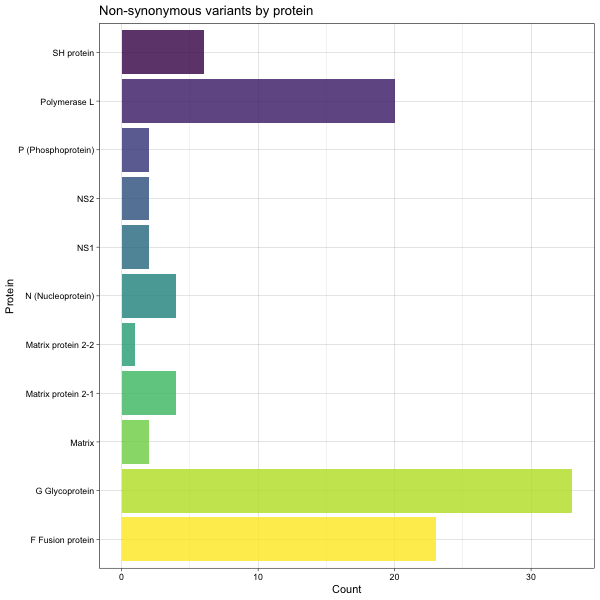

In [88]:
# barplot of variant frequencies

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
library(dplyr)
p <- variants %>% filter(is_synonymous == "No") %>% ggplot(aes(x = protein, fill = protein)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Non-synonymous variants by protein", x = "Protein", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end
